In [1]:
import pandas as pd
raw_data=pd.read_csv('../raw_data/Tool_Info.csv')
clean_data=pd.read_csv('../summary_data/table1_final.csv')
raw_data = raw_data.loc[:,['aligner', 'num_citations']]
data = pd.merge(clean_data, raw_data, on='aligner', how='outer')
data.loc[data['aligner'] == 'PatternHunter', 'num_citations'] = 954
data.loc[data['aligner'] == 'LAMSA', 'num_citations'] = 14
data.loc[data['aligner'] == 'conLSH', 'num_citations'] = 1

data['age']=2020-data['year_of_pub']+1
data['citation_per_year']=data['num_citations']/data['age']
data.loc[data.loc[:,'aligner'] == 'HISAT2', 'citation_per_year'] = 95/2


# Creating new columns that combine rarer types
data.loc[data.loc[:,'indexing'] == 'hashing', 'index'] = 'Hashing'
data.loc[data.loc[:,'indexing'] == 'BWT-FM', 'index'] = 'BWT-FM'
data.loc[data.loc[:,'indexing'] == 'BWT-FM + hashing', 'index'] = 'BWT-FM & Hashing'
data.loc[data.loc[:,'indexing'] == 'suffix array', 'index'] = 'Other Suffix'
data.loc[data.loc[:,'indexing'] == 'BWT-ST', 'index'] = 'Other Suffix'
data.loc[data.loc[:,'indexing'] == 'BWT', 'index'] = 'Other Suffix'
data.loc[data.loc[:,'indexing'] == 'suffix tree', 'index'] = 'Other Suffix'

data.loc[data.loc[:,'pairwise_alignment'] == 'SW', 'pairwise'] = 'Smith-Waterman'
data.loc[data.loc[:,'pairwise_alignment'] == 'HD', 'pairwise'] = 'Hamming Distance'
data.loc[data.loc[:,'pairwise_alignment'] == 'NW', 'pairwise'] = 'Needleman-Wunsch'
data.loc[data.loc[:,'pairwise_alignment'] == 'Non-DP Heuristic', 'pairwise'] = 'Non-DP Heuristic'
data.loc[data.loc[:,'pairwise_alignment'] == 'Non-DP heuristic', 'pairwise'] = 'Non-DP Heuristic'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW & NW', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW and NW', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW & Semi-Global', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW and Semi-Global', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'Rabin-Karp Algorithm', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Landau-Vishkin', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Sparse DP', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Banded Myers Bit Vector', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Myers Bit-Vector', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Semi-Global', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Semi-global', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'].isnull(), 'pairwise'] = 'Not Applicable'

data.loc[data.loc[:,'fix_length_seed'] == 'Y', 'seeds_fixed'] = 'Yes'
data.loc[data.loc[:,'fix_length_seed'] == 'N', 'seeds_fixed'] = 'No'

data.loc[data.loc[:,'seed_chaining'] == 'Y', 'seeds_chained'] = 'Yes'
data.loc[data.loc[:,'seed_chaining'] == 'N', 'seeds_chained'] = 'No'

data.loc[data.loc[:,'spaced_seed'] == 'Y', 'seeds_spaced'] = 'Yes'
data.loc[data.loc[:,'spaced_seed'] == 'N', 'seeds_spaced'] = 'No'

data_year = pd.DataFrame(data.loc[:,['year_of_pub', 'aligner', 'application', 'index', 
                        'pairwise', 'seeds_fixed', 'seeds_spaced', 'seeds_chained']])
data_year.loc[:,'aligner_lower'] = data_year.loc[:,'aligner'].str.lower()

data.loc[data['pairwise'].isnull(), :]

,aligner,url,year_of_pub,application,indexing,fix_length_seed,spaced_seed,seed_chaining,pairwise_alignment,wrapper,max_read_length_tested,num_citations,age,citation_per_year,index,pairwise,seeds_fixed,seeds_chained,seeds_spaced


In [2]:
cite_data = data.loc[:, ['aligner', 'num_citations', 'year_of_pub', 'citation_per_year']]
cite_data.to_csv(path_or_buf='../summary_data/tool_citation_data.csv', index=False)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as scp
import numpy as np

index_clrs = ['darkorange', 'mediumorchid', 'cornflowerblue', 'navy']

local_clrs = ['orange', 'deepskyblue', 'chocolate', 'gold', 'royalblue', 'lightseagreen']

In [8]:
idx_group = data_year.loc[data_year['application'].str.contains('DNA'),:].groupby('index')['aligner'].count().reset_index().sort_values('aligner', ascending=True)
idx_group

,index,aligner
1,BWT-FM & Hashing,3
3,Other Suffix,9
0,BWT-FM,14
2,Hashing,56


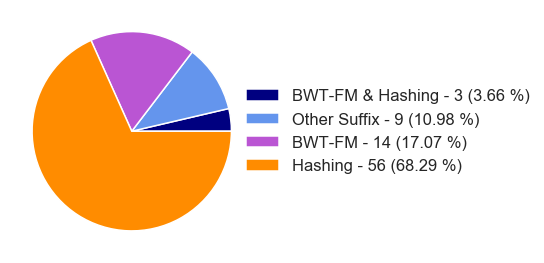

In [5]:
plt.figure(figsize=(11,4))
sns.set_style('white')
sns.set_context('talk')
idx_group = data_year.loc[data_year['application'].str.contains('DNA'),:].groupby('index').count().sort_values('aligner', ascending=True)
patches, texts = plt.pie(idx_group.aligner, colors=index_clrs[::-1])
pct = 100.*idx_group.aligner/idx_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(idx_group.index, idx_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(.9, .5), frameon=False)
plt.tight_layout()

plt.show()

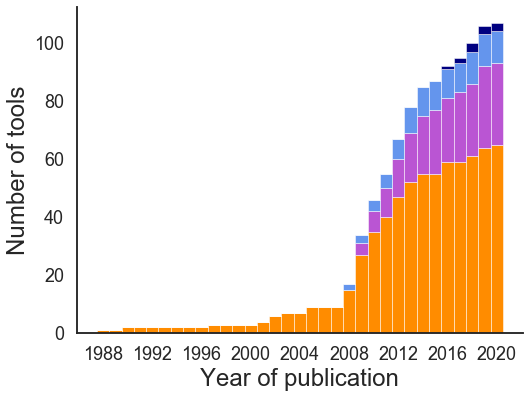

In [46]:
plt.figure(figsize=(8,6))

idx = range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+1)
by_year = data_year.groupby(['year_of_pub','index']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
by_year = by_year.reindex(idx, method='ffill')
#by_year.loc[:,'Total'] = by_year.sum(axis=1)
x = by_year.index
by_year.reset_index()
year_melt = pd.melt(by_year.reset_index(), id_vars=['year_of_pub'], var_name='Indexing Algorithm', 
                    value_name='Number of Tools')
year_melt = year_melt.rename(columns={'year_of_pub':'Year of Publication'})
year_melt.head()

sns.set_style('white')
sns.set_context('talk')

BWT = by_year['BWT-FM'].to_list()
Both = by_year['BWT-FM & Hashing'].to_list()
Hash = by_year['Hashing'].to_list()
Other = by_year['Other Suffix'].to_list()

barWidth = 1
plt.bar(x, Hash, color='darkorange', edgecolor='white', width=barWidth, linewidth=.5)
plt.bar(x, BWT, bottom=Hash, color='mediumorchid', edgecolor='white', width=barWidth, linewidth=.5)
plt.bar(x, Other, bottom=[i+j for i,j in zip(Hash, BWT)], color='cornflowerblue', 
        edgecolor='white', width=barWidth, linewidth=.5)
plt.bar(x, Both, bottom=[i+j+k for i,j,k in zip(Hash, BWT, Other)], color='navy', 
        edgecolor='white', width=barWidth, linewidth=.5)

plt.ylabel("Number of tools", fontsize=24)
plt.xlabel("Year of publication", fontsize=24)

sns.despine()

plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4), fontsize=18)
plt.yticks(fontsize=18)
# plt.show()
plt.savefig('../figures/Figure3_a.png', bbox_inches='tight')
plt.savefig('../figures/Figure3_a.pdf', bbox_inches='tight')

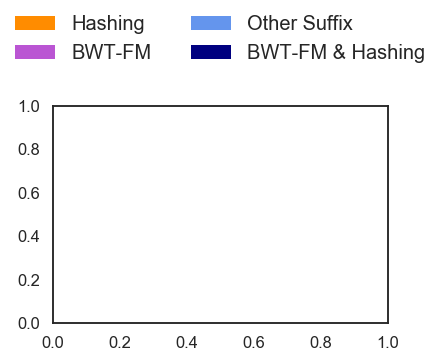

In [38]:
hashbar = plt.Rectangle((0,0),1,1,fc="darkorange", edgecolor = 'none')
bwtbar = plt.Rectangle((0,0),1,1,fc='mediumorchid', edgecolor = 'none')
otherbar = plt.Rectangle((0,0),1,1,fc='cornflowerblue', edgecolor = 'none')
bothbar = plt.Rectangle((0,0),1,1,fc='navy', edgecolor = 'none')

l = plt.legend([hashbar, bwtbar, otherbar, bothbar], ['Hashing', 'BWT-FM', 'Other Suffix', 'BWT-FM & Hashing'], 
               loc = "upper center", bbox_to_anchor=(.5,1.5), ncol = 2, prop={'size':20})
l.draw_frame(False)

plt.savefig('../figures/Figure3_a_legend.png', bbox_inches='tight')

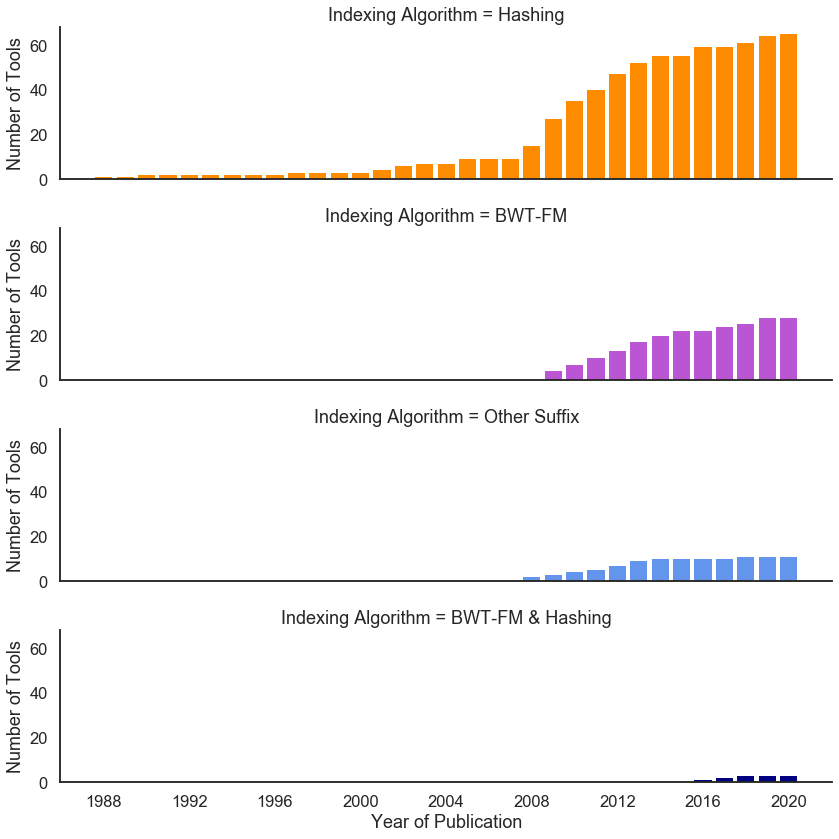

In [10]:
# plt.figure(figsize=(8,4))
sns.set_style('white')
sns.set_context('talk')

g = sns.FacetGrid(year_melt, row='Indexing Algorithm', aspect=4, hue='Indexing Algorithm', 
                  row_order=['Hashing', 'BWT-FM', 'Other Suffix', 'BWT-FM & Hashing'],
                  palette=index_clrs, hue_order=['Hashing', 'BWT-FM', 'Other Suffix', 'BWT-FM & Hashing'])
g = g.map(plt.bar, 'Year of Publication', 'Number of Tools', linewidth=0)
plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
sns.despine()

plt.show()

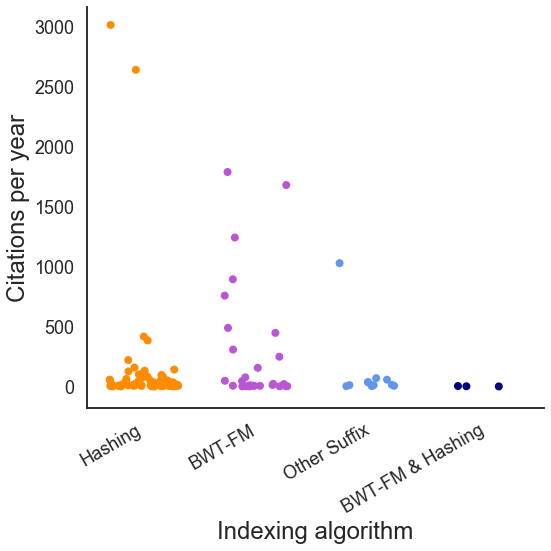

In [47]:
plt.figure(figsize=(8,8))


sns.set_style('white')
sns.set_context('talk')

ax = sns.stripplot(data = data, x = 'index', y = 'citation_per_year', 
                   order=['Hashing','BWT-FM','Other Suffix', 'BWT-FM & Hashing'], palette=index_clrs, 
                   size=8, jitter=.3)

labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=30, ha="right", fontsize=18)
plt.yticks(fontsize=18)
#ax.set(xlabel = 'Indexing algorithm', ylabel = "Citations per year")
plt.xlabel("Indexing algorithm", fontsize=24)
plt.ylabel("Citations per year", fontsize=24)

plt.tight_layout()
sns.despine()

plt.savefig('../figures/Figure3_b.png')
plt.savefig('../figures/Figure3_b.pdf')

In [24]:
mwu = scp.stats.mannwhitneyu(data.loc[data['index'] == 'Hashing'].loc[:, 'citation_per_year'], 
                       data.loc[data['index'] == 'BWT-FM'].loc[:, 'citation_per_year'])

print(mwu)

MannwhitneyuResult(statistic=821.0, pvalue=0.22927746122851772)


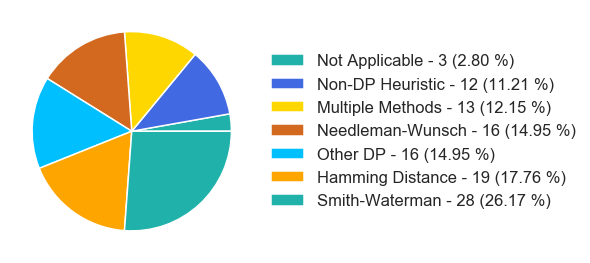

In [60]:
plt.figure(figsize=(12,4))

sns.set_style('white')
sns.set_context('talk')
pairwise_group = data_year.groupby('pairwise').count().sort_values('aligner', ascending=True)
patches, texts = plt.pie(pairwise_group.aligner, colors=local_clrs[::-1])
pct = 100.*pairwise_group.aligner/pairwise_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(pairwise_group.index, pairwise_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1, .5), frameon=False)
plt.tight_layout()
sns.despine()

plt.show()

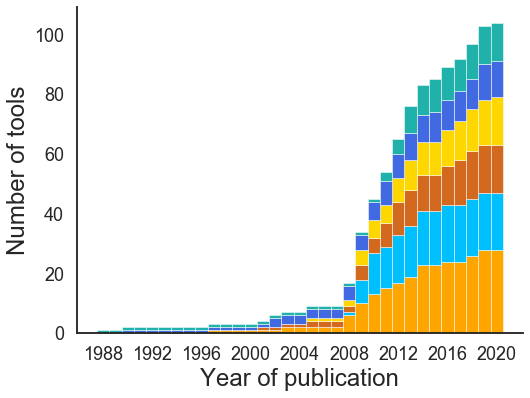

In [49]:
plt.figure(figsize=(8,6))
idx = range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+1)
by_year = data_year.groupby(['year_of_pub','pairwise']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
by_year = by_year.reindex(idx, method='ffill')
x = by_year.index
by_year.reset_index()
year_melt = pd.melt(by_year.reset_index(), id_vars=['year_of_pub'], var_name='Pairwise Alignment Algorithm', 
                    value_name='Number of Tools')
year_melt = year_melt.rename(columns={'year_of_pub':'Year of Publication'})
year_melt.head()

SW = by_year['Smith-Waterman'].to_list()
HD = by_year['Hamming Distance'].to_list()
Other = by_year['Other DP'].to_list()
NW = by_year['Needleman-Wunsch'].to_list()
MM = by_year['Multiple Methods'].to_list()
NoDP = by_year['Non-DP Heuristic'].to_list()

sns.set_style('white')
sns.set_context('talk')

# plot
barWidth = 1
#plt.bar(x, NW, color='gold', 
#        edgecolor='white', width=barWidth)

plt.bar(x, SW, color='orange', edgecolor='white', width=barWidth, linewidth=.5)
plt.bar(x, HD, bottom=SW, color='deepskyblue', edgecolor='white', width=barWidth, linewidth=.5)
plt.bar(x, NW, bottom=[i+j for i,j in zip(SW, HD)], color='chocolate', 
        edgecolor='white', width=barWidth, linewidth=.5)
plt.bar(x, Other, bottom=[i+j+k for i,j,k in zip(SW, HD, NW)], color='gold', 
        edgecolor='white', width=barWidth, linewidth=.5)
plt.bar(x, NoDP, bottom=[i+j+k+l for i,j,k,l in zip(SW, HD, Other, NW)], color='royalblue', 
        edgecolor='white', width=barWidth, linewidth=.5)
plt.bar(x, MM, bottom=[i+j+k+l+m for i,j,k,l,m in zip(SW, HD, Other, NW, NoDP)], color='lightseagreen', 
        edgecolor='white', width=barWidth, linewidth=.5)

sns.despine()
plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4), fontsize=18)
plt.yticks(fontsize=18)

plt.ylabel("Number of tools", fontsize=24)
plt.xlabel("Year of publication", fontsize=24)
# plt.tight_layout()
#plt.show()

plt.savefig('../figures/Figure3_c.png', bbox_inches='tight')
plt.savefig('../figures/Figure3_c.pdf', bbox_inches='tight')

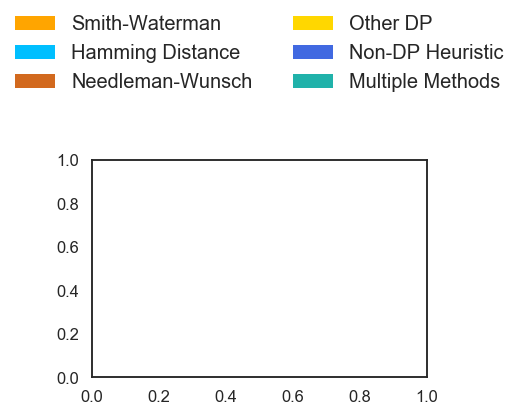

In [40]:
local_clrs = ['orange', 'deepskyblue', 'chocolate', 'gold', 'royalblue', 'lightseagreen']

swbar = plt.Rectangle((0,0),1,1,fc="orange", edgecolor = 'none')
hdbar = plt.Rectangle((0,0),1,1,fc='deepskyblue', edgecolor = 'none')
nwbar = plt.Rectangle((0,0),1,1,fc='chocolate', edgecolor = 'none')
otherbar = plt.Rectangle((0,0),1,1,fc='gold', edgecolor = 'none')
ndpbar = plt.Rectangle((0,0),1,1,fc='royalblue', edgecolor = 'none')
mmbar = plt.Rectangle((0,0),1,1,fc='lightseagreen', edgecolor = 'none')

l = plt.legend([swbar, hdbar, nwbar, otherbar, ndpbar, mmbar], 
               ['Smith-Waterman', 'Hamming Distance', 'Needleman-Wunsch', 'Other DP', 
                'Non-DP Heuristic', 'Multiple Methods'], 
               loc = "upper center", bbox_to_anchor=(.5,1.75), ncol = 2, prop={'size':20})
l.draw_frame(False)

plt.savefig('../figures/Figure3_c_legend.png', bbox_inches='tight')

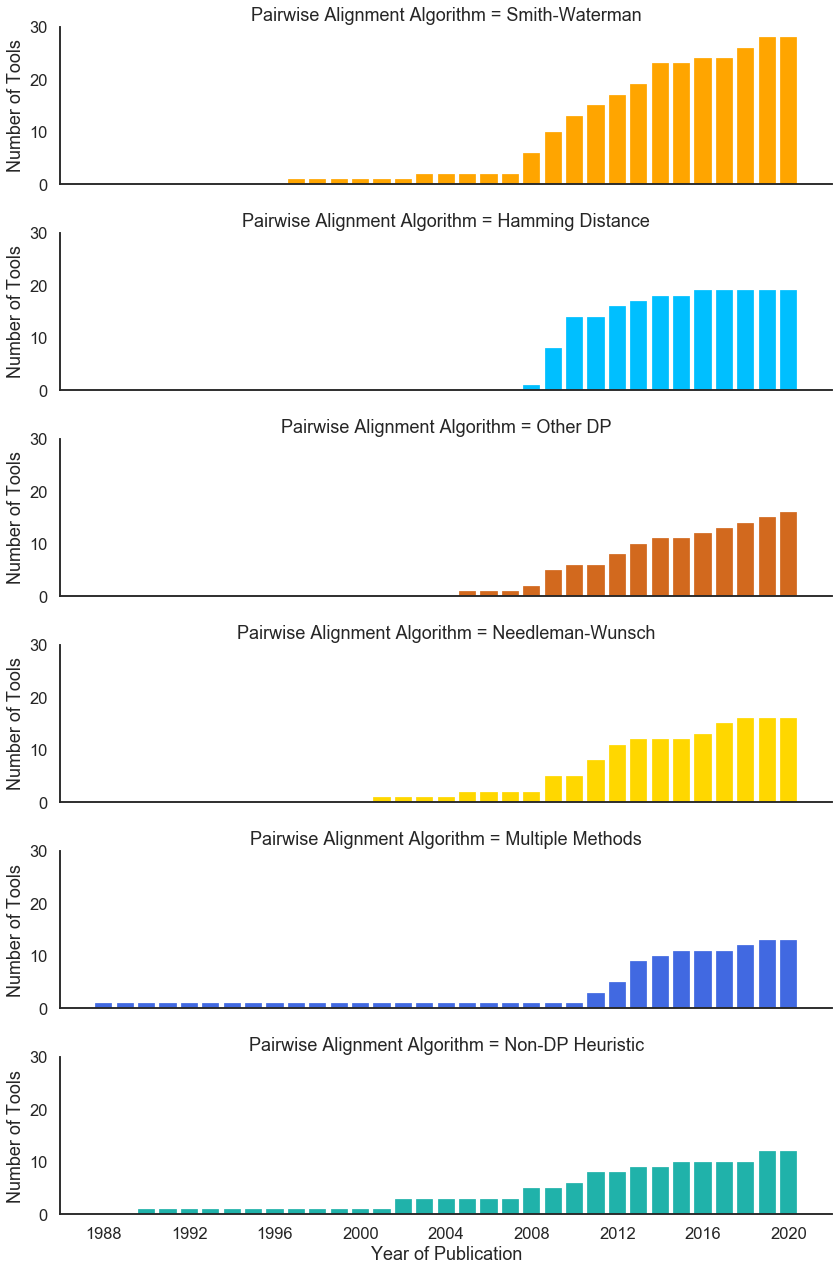

In [64]:
sns.set_style('white')
sns.set_context('talk')

g = sns.FacetGrid(year_melt, row='Pairwise Alignment Algorithm', aspect=4, hue='Pairwise Alignment Algorithm', 
                  row_order=['Smith-Waterman', 'Hamming Distance', 'Other DP', 'Needleman-Wunsch', 'Multiple Methods',
                            'Non-DP Heuristic'],
                  palette=local_clrs, hue_order=['Smith-Waterman', 'Hamming Distance', 'Other DP', 'Needleman-Wunsch',
                                                 'Multiple Methods', 'Non-DP Heuristic'])
g = g.map(plt.bar, 'Year of Publication', 'Number of Tools', linewidth=.25)
plt.ylim(0, 30)
plt.xticks(range(min(data_year['year_of_pub']), max(data_year['year_of_pub'])+2, 4))
sns.despine()

plt.show()

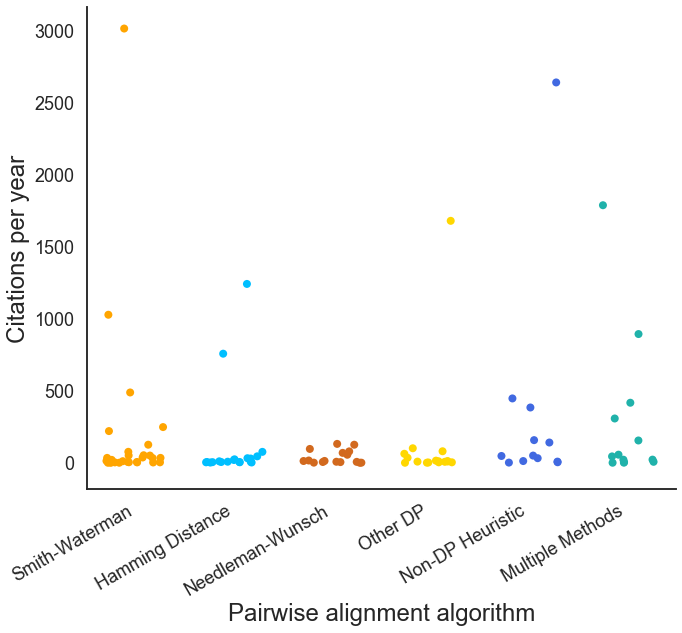

In [6]:
plt.figure(figsize=(10,8))

sns.set_style('white')
sns.set_context('talk')

ax = sns.stripplot(data=data, x='pairwise', y='citation_per_year',  
                order=['Smith-Waterman', 'Hamming Distance', 'Needleman-Wunsch', 'Other DP',
                     'Non-DP Heuristic', 'Multiple Methods'], palette=local_clrs, size=8, jitter=.3)

#ax.set(xlabel = 'Pairwise alignment algorithm', ylabel = "Citations per year")
plt.xlabel("Pairwise alignment algorithm", fontsize=24)
plt.ylabel("Citations per year", fontsize=24)
plt.tight_layout()
sns.despine()
labels = ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=30, ha="right", fontsize=18)
plt.yticks(fontsize=18)
#plt.show()
plt.savefig('../figures/Figure3_d.png', bbox_inches='tight')
plt.savefig('../figures/Figure3_d.pdf', bbox_inches='tight')

In [37]:
mwu = scp.stats.mannwhitneyu(data.loc[data['indexing'] == 'BWT-FM', 'citation_per_year'], 
                       data.loc[data['indexing'] == 'hashing', 'citation_per_year'])

print(len(data.loc[data['indexing'] == 'BWT-FM', 'citation_per_year']))
print(len(data.loc[data['indexing'] == 'hashing', 'citation_per_year']))

28
65


In [113]:
test = data.loc[:,['aligner', 'indexing', 'pairwise', 'citation_per_year']].sort_values(by='citation_per_year', 
                                                                                 ascending=False)
test

,aligner,indexing,pairwise,citation_per_year
2,Gapped BLAST,hashing,Smith-Waterman,3012.333333
1,BLAST,hashing,Non-DP Heuristic,2638.451613
58,Bowtie2,BWT-FM,Multiple Methods,1786.777778
20,BWA,BWT-FM,Other DP,1678.583333
21,Bowtie,BWT-FM,Hamming Distance,1240.833333
75,STAR,suffix array,Smith-Waterman,1027.125000
76,TopHat2,BWT-FM,Multiple Methods,893.250000
33,TopHat,BWT-FM,Hamming Distance,757.000000
35,BWA-SW,BWT-FM,Smith-Waterman,488.000000
86,HISAT,BWT-FM,Non-DP Heuristic,446.666667


In [114]:
data.loc[:,['aligner', 'indexing', 'pairwise', 'year_of_pub']].sort_values(by='year_of_pub')


,aligner,indexing,pairwise,year_of_pub
0,FASTA,hashing,Multiple Methods,1988
1,BLAST,hashing,Non-DP Heuristic,1990
2,Gapped BLAST,hashing,Smith-Waterman,1997
3,SSAHA,hashing,Needleman-Wunsch,2001
4,PatternHunter,hashing,Non-DP Heuristic,2002
5,BLAT,hashing,Non-DP Heuristic,2002
6,BLASTZ,hashing,Smith-Waterman,2003
7,C4,hashing,Other DP,2005
8,GMAP,hashing,Needleman-Wunsch,2005
16,QPALMA,suffix array,Smith-Waterman,2008


In [40]:
new_test = data.loc[data['pairwise'] == 'Multiple Methods', 'pairwise_alignment']
new_test

0             SW and NW
46              SW & NW
47              SW & NW
58              SW & NW
59              SW & NW
67              SW & NW
69              SW & NW
71              SW & NW
76              SW & NW
79     SW & Semi-Global
85              SW & NW
99              SW & NW
100             SW & NW
Name: pairwise_alignment, dtype: object